In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/BSURE

/content/drive/MyDrive/BSURE


In [3]:
!apt-get update -qq
!apt-get install -qq gdal-bin libgdal-dev
!pip install --quiet sentinelhub geopandas fiona rasterio matplotlib pandas

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package python3-numpy.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Selecting previously unselected package python3-gdal.
Preparing to unpack .../python3-gdal_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking python3-gdal (3.8.4+dfsg-1~jammy0) ...
Selecting previously unselected package gdal-bin.
Preparing to unpack .../gdal-bin_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking gdal-bin (3.8.4+dfsg-1~jammy0) ...
Setting up python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Setting up python3-gdal (3.8.4+dfsg-1~jammy0) ...
Setting up gdal-bin (3.8.4+dfsg-1~jammy0) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━

In [4]:
import os
import glob
import numpy as np
import rasterio
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [ ]:
#!cp -r "/content/drive/MyDrive/BSURE/NEW_downloads" /tmp/bsure_data

^C


In [5]:
def gp_label(patch, z_strict=1.96, z_moderate=1.0):
    mean_series = np.nanmean(patch, axis=(1, 2))

    #check valid data
    if np.all(np.isnan(mean_series)) or np.sum(~np.isnan(mean_series)) < 3:
        return 0

    #remove NaN values
    valid_indices = ~np.isnan(mean_series)
    if np.sum(valid_indices) < 3:
        return 0

    times = np.arange(len(mean_series))[valid_indices][:-1].reshape(-1, 1)
    y = mean_series[valid_indices][:-1]

    if len(y) < 2:
        return 0

    #Fit GP
    kernel = RBF(length_scale=2.0) + WhiteKernel(noise_level=1e-2)
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=1e-6)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        try:
            gp.fit(times, y)
        except:
            return 0

    #predict
    last_time = np.array([[len(mean_series[valid_indices]) - 1]])
    mu_arr, std_arr = gp.predict(last_time, return_std=True)
    mu, std = mu_arr.item(), std_arr.item()

    obs = np.nanmean(patch[-1])
    if np.isnan(obs):
        return 0

    #calc sens bounds
    lower_strict, upper_strict = mu - z_strict * std, mu + z_strict * std
    lower_moderate, upper_moderate = mu - z_moderate * std, mu + z_moderate * std

    #classification
    if (obs < lower_strict) or (obs > upper_strict):
        return 2  #strong change
    elif (obs < lower_moderate) or (obs > upper_moderate):
        return 1  #moderate change
    else:
        return 0  #no change

In [6]:
#base_dir = "/tmp/bsure_data"
base_dir = "/content/drive/MyDrive/BSURE/NEW_downloads"
all_aois = [
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
]

test_aois = [
    "Alau_dam",
    "ToddbrookReservoir",
    "Indus River Basin",
    "RiverAvonSevern_Tewkesbury"
]

#separate test 4
train_aois = [aoi for aoi in all_aois if aoi not in test_aois]

print("All AOIs:", all_aois)
print("Training AOIs:", train_aois)
print("Testing  AOIs:", test_aois)

All AOIs: ['Bartley3', 'RBshpSttn', 'Kakh', 'Black Forest - Germany', 'California Central Valley - USA', 'Lena River - Russia', 'Mississippi River Delta - USA', 'Pantanal Wetlands - Mato Grosso', 'Alau_dam', 'Indus River Basin', 'RiverAvonSevern_Tewkesbury', 'ToddbrookReservoir']
Training AOIs: ['Bartley3', 'RBshpSttn', 'Kakh', 'Black Forest - Germany', 'California Central Valley - USA', 'Lena River - Russia', 'Mississippi River Delta - USA', 'Pantanal Wetlands - Mato Grosso']
Testing  AOIs: ['Alau_dam', 'ToddbrookReservoir', 'Indus River Basin', 'RiverAvonSevern_Tewkesbury']


In [7]:
min_T = 11
print(f"Using T = {min_T} frames for all AOIs")

Using T = 11 frames for all AOIs


In [ ]:
#frame_counts = [len(v) for v in aoi_tif_seqs.values()]
#min_T = min(frame_counts)
#print(f"Using T = {min_T} frames for all AOIs")

In [8]:
def check_label_distribution(samples, label_names=['No Change', 'Moderate Change', 'Strong Change']):
    labels = [sample[1] for sample in samples]
    class_counts = Counter(labels)
    total = len(labels)

    print("Label Distribution:")
    print("-" * 40)
    for label, count in class_counts.items():
        percentage = (count / total) * 100
        print(f"{label_names[label]}: {count:,} ({percentage:.1f}%)")

    return class_counts

In [9]:
def preprocess_patch(patch):
    patch = np.where(np.isnan(patch), np.nanmean(patch), patch)
    patch = np.clip(patch, -1, 1)
    patch = (patch + 1) / 2

    return patch.astype(np.float32)

In [ ]:
patch_size, stride = 32, 16
train_samples = []

for aoi in train_aois:
    print(f"Processing {aoi}...")
    tif_list = glob.glob(os.path.join(base_dir, aoi, "NDVI", "*", "response.tiff"))
    if not tif_list:
        continue

    #H×W crop
    ndvi_seq = []
    shapes = []
    for path in tif_list[:min_T]:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
        shapes.append(arr.shape)
        ndvi_seq.append(arr)

    minH = min(h for h, w in shapes)
    minW = min(w for h, w in shapes)
    ndvi_seq = [arr[:minH, :minW] for arr in ndvi_seq]

    while len(ndvi_seq) < min_T:
        ndvi_seq.append(ndvi_seq[-1].copy())

    ndvi_stack = np.stack(ndvi_seq, axis=0)
    T, H, W = ndvi_stack.shape

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = ndvi_stack[:, i:i+patch_size, j:j+patch_size]
            lbl = gp_label(patch)
            train_samples.append((patch, lbl))

print(f"Total training patches: {len(train_samples)}")

train_class_counts = check_label_distribution(train_samples)

In [11]:
patch_size, stride = 32, 16
test_samples = []

for aoi in test_aois:
    print(f"Processing {aoi}...")
    tif_list = glob.glob(os.path.join(base_dir, aoi, "NDVI", "*", "response.tiff"))
    if not tif_list:
        continue

    ndvi_seq = []
    shapes = []
    for path in tif_list[:min_T]:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
        shapes.append(arr.shape)
        ndvi_seq.append(arr)

    minH = min(h for h, w in shapes)
    minW = min(w for h, w in shapes)
    ndvi_seq = [arr[:minH, :minW] for arr in ndvi_seq]

    while len(ndvi_seq) < min_T:
        ndvi_seq.append(ndvi_seq[-1].copy())

    ndvi_stack = np.stack(ndvi_seq, axis=0)
    T, H, W = ndvi_stack.shape

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = ndvi_stack[:, i:i+patch_size, j:j+patch_size]
            lbl = gp_label(patch)
            test_samples.append((patch, lbl))

print(f"Total test patches: {len(test_samples)}")
test_class_counts = check_label_distribution(test_samples)

Processing Alau_dam...
Processing ToddbrookReservoir...
Processing Indus River Basin...
Processing RiverAvonSevern_Tewkesbury...
Total test patches: 16556
Label Distribution:
----------------------------------------
Moderate Change: 3,091 (18.7%)
Strong Change: 1,978 (11.9%)
No Change: 11,487 (69.4%)


In [12]:
class ChangeDataset(Dataset):
    def __init__(self, samples, augment=False):
        self.samples = samples
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        stack, lbl = self.samples[i]

        stack = preprocess_patch(stack)

        if self.augment:
            if np.random.rand() > 0.5:
                stack = np.flip(stack, axis=2).copy()
            if np.random.rand() > 0.5:
                stack = np.flip(stack, axis=1).copy()
            if np.random.rand() > 0.5:
                k = np.random.choice([1, 2, 3])
                stack = np.rot90(stack, k=k, axes=(1, 2)).copy()

        x = torch.from_numpy(stack)
        y = torch.tensor(lbl).long()
        return x, y

In [13]:
class CNN3D(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.temporal_conv = nn.Sequential(
            nn.Conv3d(1, 32, (3, 1, 1), padding=(1, 0, 0)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 64, (3, 1, 1), padding=(1, 0, 0)),
            nn.BatchNorm3d(64),
            nn.ReLU()
        )

        self.spatial_conv = nn.Sequential(
            nn.Conv3d(64, 128, (1, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(128, 256, (1, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.AdaptiveAvgPool3d((1, 1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

        self.temporal_attention = nn.Sequential(
            nn.AdaptiveAvgPool3d((None, 1, 1)),
            nn.Conv3d(256, 128, (1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(128, 1, (1, 1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.temporal_conv(x)

        x = self.spatial_conv(x)

        out = self.classifier(x)

        return out

In [15]:
def train_model(train_samples, test_samples, num_epochs=11):
    train_ds = ChangeDataset(train_samples, augment=True)
    test_ds = ChangeDataset(test_samples, augment=False)

    labels = [sample[1] for sample in train_samples]
    class_counts = Counter(labels)
    print(f"Training class distribution: {class_counts}")

    if len(class_counts) == 1:
        return None

    #class weights
    total_samples = len(labels)
    class_weights = {cls: total_samples / (len(class_counts) * count)
                    for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]

    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN3D(num_classes=len(class_counts)).to(device)
    print(f"Using device: {device}")

    class_weight_tensor = torch.tensor([class_weights[i] for i in sorted(class_weights.keys())],
                                     dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    best_f1 = 0
    train_losses, val_f1s = [], []

    for epoch in range(1, num_epochs + 1):
        #train loop
        model.train()
        losses = []
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            losses.append(loss.item())

        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)

        #val
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in tqdm(test_loader, desc="Validation"):
                xb = xb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        val_f1s.append(f1)

        scheduler.step(f1)

        print(f"Epoch {epoch}: Loss={avg_loss:.4f} | Acc={acc:.3f} | F1={f1:.3f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_model.pth')

    #eval
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)
    print(f"Best F1 Score: {best_f1:.3f}")
    print("\nClassification Report:")

    class_names = []
    for i in sorted(class_counts.keys()):
        if i == 0:
            class_names.append('No Change')
        elif i == 1:
            class_names.append('Moderate Change')
        elif i == 2:
            class_names.append('Strong Change')

    print(classification_report(all_labels, all_preds, target_names=class_names))

    #confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    #training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s)
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()

    return model, test_loader, device

Training class distribution: Counter({0: 10188, 2: 7406, 1: 6371})
Using device: cuda


Validation: 100%|██████████| 1035/1035 [00:24<00:00, 41.86it/s]


Epoch 1: Loss=0.6161 | Acc=0.729 | F1=0.736


Validation: 100%|██████████| 1035/1035 [00:25<00:00, 41.34it/s]


Epoch 2: Loss=0.4784 | Acc=0.754 | F1=0.774


Validation: 100%|██████████| 1035/1035 [00:24<00:00, 42.38it/s]


Epoch 3: Loss=0.4567 | Acc=0.419 | F1=0.492


Validation: 100%|██████████| 1035/1035 [00:25<00:00, 41.40it/s]


Epoch 4: Loss=0.4356 | Acc=0.705 | F1=0.712


Validation: 100%|██████████| 1035/1035 [00:24<00:00, 42.71it/s]


Epoch 5: Loss=0.4173 | Acc=0.756 | F1=0.770


Validation: 100%|██████████| 1035/1035 [00:25<00:00, 40.81it/s]


Epoch 6: Loss=0.4154 | Acc=0.542 | F1=0.584


Validation: 100%|██████████| 1035/1035 [00:24<00:00, 42.50it/s]


Epoch 7: Loss=0.4072 | Acc=0.663 | F1=0.694


Validation: 100%|██████████| 1035/1035 [00:25<00:00, 40.99it/s]


Epoch 8: Loss=0.3815 | Acc=0.623 | F1=0.658


Validation: 100%|██████████| 1035/1035 [00:24<00:00, 42.43it/s]


Epoch 9: Loss=0.3761 | Acc=0.789 | F1=0.795


Validation: 100%|██████████| 1035/1035 [00:25<00:00, 41.32it/s]


Epoch 10: Loss=0.3750 | Acc=0.653 | F1=0.684


Validation: 100%|██████████| 1035/1035 [00:24<00:00, 42.73it/s]


Epoch 11: Loss=0.3649 | Acc=0.694 | F1=0.715

FINAL EVALUATION
Best F1 Score: 0.795

Classification Report:
                 precision    recall  f1-score   support

      No Change       0.92      0.74      0.82     11487
Moderate Change       0.37      0.47      0.41      3091
  Strong Change       0.46      0.81      0.59      1978

       accuracy                           0.69     16556
      macro avg       0.58      0.67      0.61     16556
   weighted avg       0.76      0.69      0.71     16556



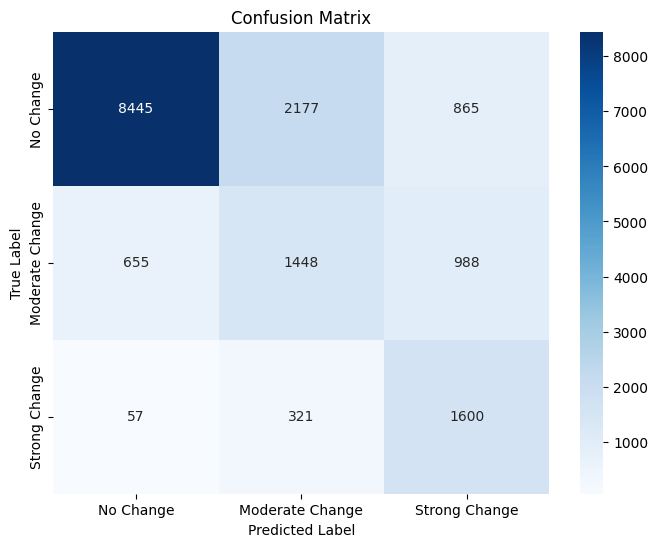

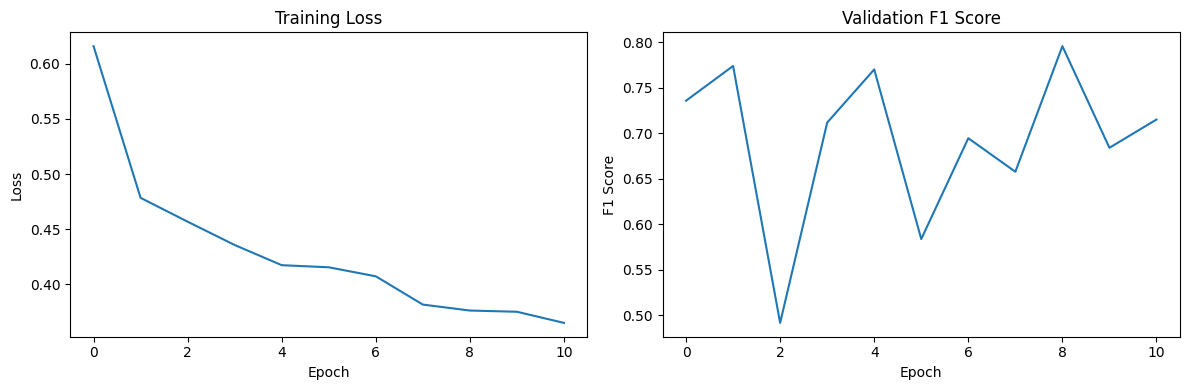

In [16]:
model, test_loader, device = train_model(train_samples, test_samples, num_epochs=11)

In [17]:
def visualize_changes(model, test_loader, device, num_examples=9):
    model.eval()
    changed_patches = []
    change_probs = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            for i, (pred, prob, true_label) in enumerate(zip(preds, probs, yb)):
                if pred.item() > 0:
                    patch = xb[i].cpu().numpy()
                    patch = patch * 2 - 1

                    changed_patches.append({
                        'patch': patch,
                        'pred_class': pred.item(),
                        'true_class': true_label.item(),
                        'confidence': prob[pred].item(),
                        'change_prob': (prob[1] + prob[2]).item() if len(prob) > 2 else prob[1].item()
                    })

    if len(changed_patches) == 0:
        print("No changes detected!")
        return

    changed_patches.sort(key=lambda x: x['confidence'], reverse=True)

    N = min(num_examples, len(changed_patches))
    rows = (N + 2) // 3

    fig, axes = plt.subplots(rows, 6, figsize=(18, 3 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx in range(N):
        row = idx // 3
        col_base = (idx % 3) * 2

        patch_info = changed_patches[idx]
        patch = patch_info['patch']

        before = patch[0]
        after = patch[-1]

        change_map = after - before

        ax1 = axes[row, col_base]
        im1 = ax1.imshow(before, cmap='RdYlGn', vmin=-1, vmax=1)
        ax1.set_title(f'Before\nPred: {patch_info["pred_class"]}, True: {patch_info["true_class"]}')
        ax1.axis('off')

        ax2 = axes[row, col_base + 1]
        im2 = ax2.imshow(after, cmap='RdYlGn', vmin=-1, vmax=1)
        ax2.set_title(f'After\nConf: {patch_info["confidence"]:.3f}')
        ax2.axis('off')

    for idx in range(N, rows * 3):
        row = idx // 3
        col_base = (idx % 3) * 2
        if row < rows:
            axes[row, col_base].remove()
            axes[row, col_base + 1].remove()

    plt.tight_layout()
    plt.show()

    print(f"Detected {len(changed_patches)} changed patches")
    print(f"Average confidence: {np.mean([p['confidence'] for p in changed_patches]):.3f}")

Visualizing detected changes...


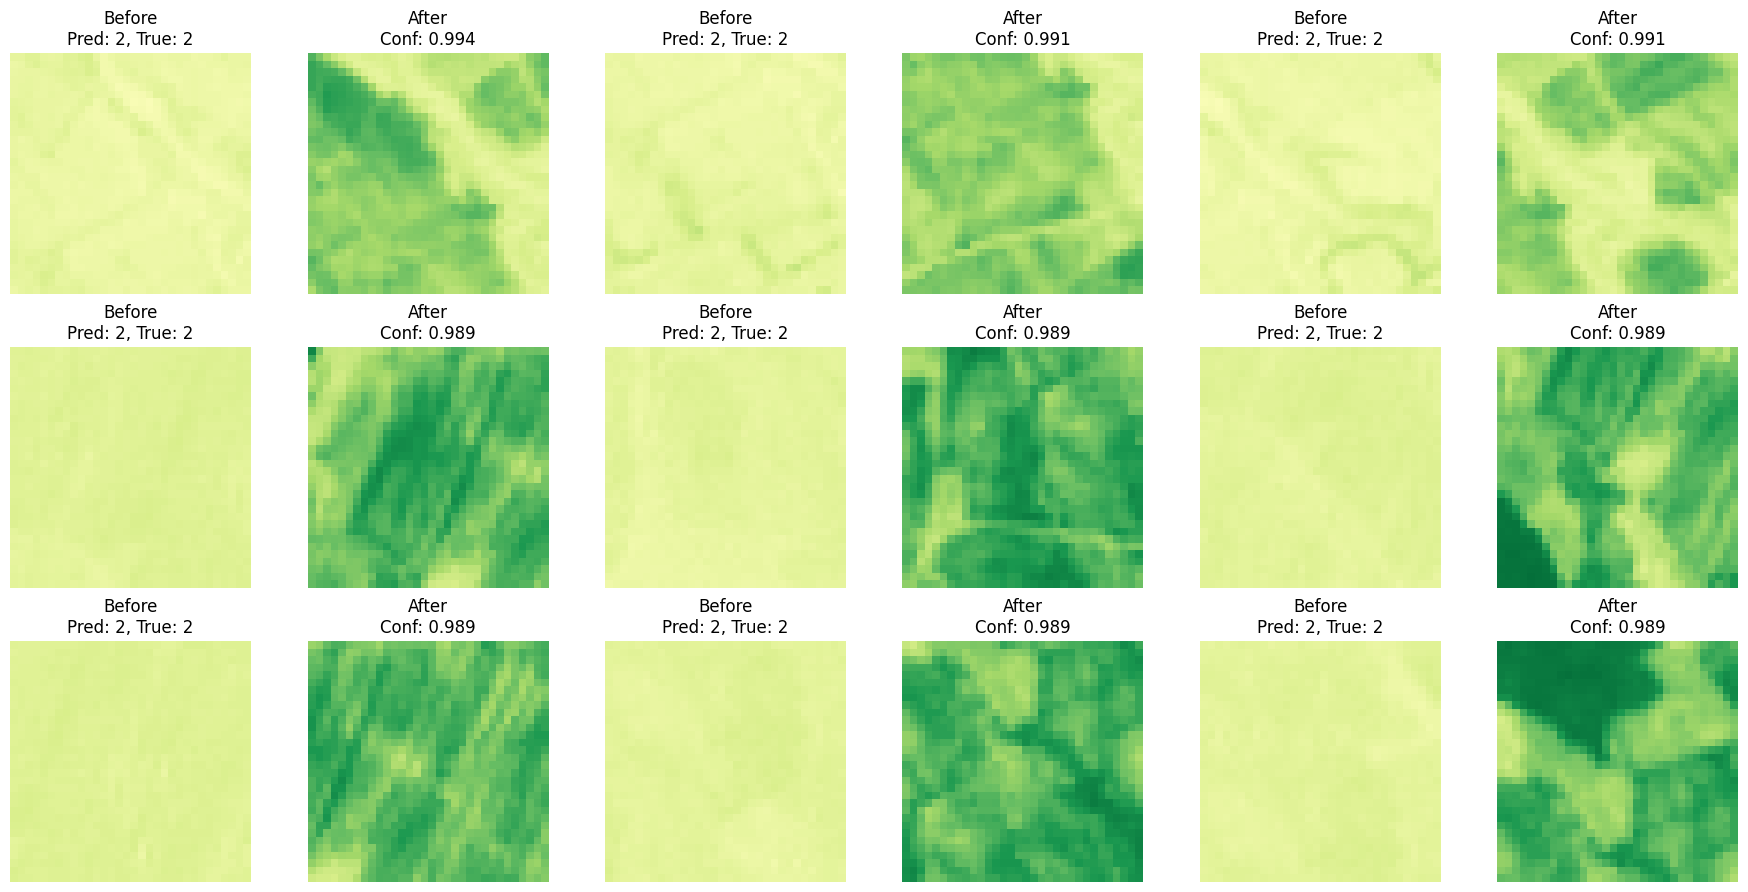

Detected 7399 changed patches
Average confidence: 0.664


In [18]:
if model is not None:
    print("Visualizing detected changes...")
    visualize_changes(model, test_loader, device)